In [ ]:
import os
import zipfile 
import gdown
import torch
from natsort import natsorted
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image
%matplotlib inline 
plt.style.use("ggplot")
## Fetch data from Google Drive 
# Root directory for the dataset
data_root = 'data/celeba'
# Path to folder with the dataset
dataset_folder = f'{data_root}/img_align_celeba'
# URL for the CelebA dataset
url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'
# url = 'https://drive.google.com/file/d/17q8bNXwqTjxskSXEQP4msZZ0RPgsyKTE'
# Path to download the dataset to
download_path = f'{data_root}/img_align_celeba.zip'


## Setup
class CFG:
  batch_size = 1024
  num_epochs = 10
  workers = 4
  seed = 2021
  image_size = 64
  img_folder = f'{dataset_folder}/img_align_celeba'
  nc = 3 ## number chanels
  ngf = 64 #Size of feature maps in generator
  nz = 100 #latent random input vector
  ndf = 64 #Size of feature maps in discriminator
  lr = 0.0002
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  sample_dir = "/content/images/"

if not os.path.exists(CFG.sample_dir):
  os.makedirs(CFG.sample_dir)

if torch.cuda.is_available():
  !nvidia-smi

# Create required directories 
if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(dataset_folder)

  # Download the dataset from google drive
  gdown.download(url, download_path, quiet=False)

  # Unzip the downloaded file 
  with zipfile.ZipFile(download_path, 'r') as ziphandler:
    ziphandler.extractall(dataset_folder)

## Create a custom Dataset class
class CelebADataset(Dataset):
  def __init__(self, root_dir, transform=None):
    """
    Args:
      root_dir (string): Directory with all the images
      transform (callable, optional): transform to be applied to each image sample
    """
    # Read names of images in the root directory
    image_names = os.listdir(root_dir)

    self.root_dir = root_dir
    self.transform = transform 
    self.image_names = natsorted(image_names)

  def __len__(self): 
    return len(self.image_names)

  def __getitem__(self, idx):
    # Get the path to the image 
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    # Load image and convert it to RGB
    img = Image.open(img_path).convert('RGB')
    # Apply transformations to the image
    if self.transform:
      img = self.transform(img)
    return img

transform=transforms.Compose([
    transforms.Resize(CFG.image_size),
    transforms.CenterCrop(CFG.image_size),
    transforms.ToTensor()   
])

## Create a dataset, dataloader 
dataset = CelebADataset(CFG.img_folder, transform)
dataloader = DataLoader(dataset, batch_size=CFG.batch_size, shuffle=True)

Thu Dec  2 20:22:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Downloading...
From: https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:09<00:00, 147MB/s]


In [ ]:
### return the shape of image
dataset[0].shape

torch.Size([3, 64, 64])

(array([ 9., 37., 16., 38.,  0.,  0.,  0.,  0.,  0.,  2., 95.,  3.,  0.,
         5., 95.]),
 array([0.7921569 , 0.8060131 , 0.8198693 , 0.8337255 , 0.8475817 ,
        0.8614379 , 0.87529415, 0.8891503 , 0.90300655, 0.9168627 ,
        0.93071896, 0.9445752 , 0.95843136, 0.9722876 , 0.98614377,
        1.        ], dtype=float32),
 <a list of 15 Patch objects>)

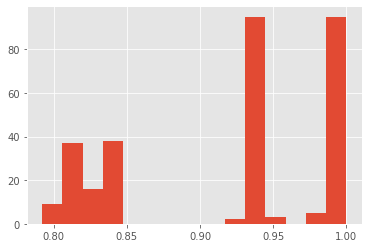

In [ ]:
### Plot the histogram of images's value
img = dataset[0]
plt.hist(img[:,5:15,5:15].flatten(), bins=15)

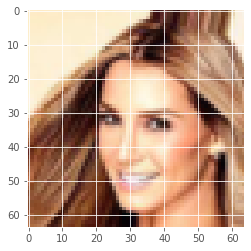

In [ ]:
# show  image sample with matplotlib
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

## Define the model

- Generator network
![generator](https://github.com/manhlab/practike-gan-2021/blob/main/06-cDcGAN-celebA-metrics/generator.png?raw=true)

- Discrimator network
![discrimator](https://github.com/manhlab/practike-gan-2021/blob/main/06-cDcGAN-celebA-metrics/discrimator.png?raw=true)

In [ ]:
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        """
          nc - количество слоев в возвращаемом (и исходном изображениях)
          nz - длина входного вектора латентного пространства
          ngf - размер feature map'ов в генераторе
        """
        #ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu 
        #ConvTranspose2d - BatchNorm - Relu - ConvTranspose2d - Tanh
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        """
          nc - количество слоев во входных изображениях
          ndf - размер feature map'ов в дискриминаторе
        """
        #conv2d - leaky - conv2d - batchnorm - leaky - conv2d - batchnorm - leaky - conv - batchnorm - leaky - conv2d
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            SpectralNorm(nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0)),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create model: Generator and Discriminator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# create new Generator model
G = Generator(CFG.nc, CFG.nz, CFG.ngf).to(device)

D = Discriminator(CFG.nc, CFG.ndf).to(device)

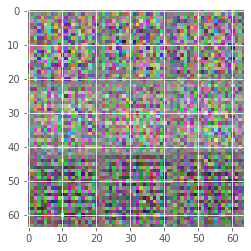

In [ ]:
# test the generator: create random vector to fit the networks, then show the result with matplotlib
noise = torch.randn(2, CFG.nz, 1, 1, device=device)
y = G(noise)

# Вывод необученного генератора
plt.imshow(y.detach().cpu()[0].view(64, 64, 3))
plt.show()

In [ ]:
from torchsummary import summary
D.to(CFG.device)
summary(D, input_size=(3, 64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
      SpectralNorm-1           [-1, 64, 32, 32]               0
         LeakyReLU-2           [-1, 64, 32, 32]               0
      SpectralNorm-3          [-1, 128, 16, 16]               0
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
      SpectralNorm-6            [-1, 256, 8, 8]               0
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
      SpectralNorm-9            [-1, 512, 4, 4]               0
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
     SpectralNorm-12              [-1, 1, 1, 1]               0
          Flatten-13                    [-1, 1]               0
          Sigmoid-14                   

In [ ]:
image = dataset[0].unsqueeze(0).to(device)
print(y.shape)
print(image.shape)
print(D(y))
print(D(image))

torch.Size([2, 3, 64, 64])
torch.Size([1, 3, 64, 64])
tensor([[0.4194],
        [0.4982]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.3957]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
## define the loss, and optimizers for generator and discrimator networks
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator
optimizer_g = torch.optim.Adam(G.parameters(), lr=CFG.lr, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(D.parameters(), lr=CFG.lr, betas=(0.5, 0.999))

In [ ]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    optimizer_g.zero_grad()
    optimizer_d.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(images.size(0), 1).to(device)
    fake_labels = torch.zeros(images.size(0), 1).to(device)

    real_preds = D(images).to(device)

    d_loss_real = criterion(real_preds, real_labels)
    real_score = torch.mean(real_preds).item()

    # Loss for fake images
    z = torch.randn(images.size(0), CFG.nz, 1, 1).to(device)
    fake_images = G(z).to(device)

    fake_preds = D(fake_images).to(device)

    d_loss_fake = criterion(fake_preds, fake_labels)
    fake_score = torch.mean(fake_preds).item()

    # Sum losses
    loss = d_loss_real + d_loss_fake

    reset_grad()
    # Compute gradients
    loss.backward()

    # Adjust the parameters using backprop
    optimizer_d.step()
    
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(CFG.batch_size, CFG.nz, 1,1).to(device)
    fake_images = G(z).to(device)
    labels = torch.ones(CFG.batch_size, 1).to(device)
    # calculate the generator loss
    preds = D(fake_images).to(device)
    loss = criterion(preds, labels)
    
    reset_grad()
    # Backprop and optimize
    loss.backward()
    optimizer_g.step()

    return loss.item(), fake_images

In [ ]:
# save some photo to show the result
def save_fake_images(index):
    sample_vectors = torch.randn(10, CFG.nz , 1 , 1).to(CFG.device)
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(fake_images, os.path.join(CFG.sample_dir, fake_fname), nrow=10)

In [ ]:
%%time
total_step = len(dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

for epoch in range(num_epochs):
    for i, (images) in enumerate(dataloader):
        # Load a batch & transform to vectors
        images = images.to(device)
        
        # Train the discriminator  
        d_loss, real_score, fake_score = train_discriminator(images)
        # Train the generator
        g_loss, _ = train_generator()
        # Inspect the losses
        if (i+1) % 50 == 0:
            d_losses.append(d_loss)
            g_losses.append(g_loss)
            real_scores.append(real_score)
            fake_scores.append(fake_score)
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss, g_loss, 
                          real_score, fake_score))
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/10], Step [50/198], d_loss: 0.4918, g_loss: 4.1622, D(x): 0.81, D(G(z)): 0.15
Epoch [0/10], Step [100/198], d_loss: 1.7952, g_loss: 1.3494, D(x): 0.29, D(G(z)): 0.05
Epoch [0/10], Step [150/198], d_loss: 2.0510, g_loss: 2.2490, D(x): 0.23, D(G(z)): 0.04
Saving fake_images-0001.png
Epoch [1/10], Step [50/198], d_loss: 1.3111, g_loss: 2.8238, D(x): 0.69, D(G(z)): 0.54
Epoch [1/10], Step [100/198], d_loss: 1.0372, g_loss: 2.7157, D(x): 0.63, D(G(z)): 0.38
Epoch [1/10], Step [150/198], d_loss: 2.5749, g_loss: 1.5799, D(x): 0.15, D(G(z)): 0.02
Saving fake_images-0002.png
Epoch [2/10], Step [50/198], d_loss: 1.4537, g_loss: 4.1944, D(x): 0.85, D(G(z)): 0.69
Epoch [2/10], Step [100/198], d_loss: 0.8023, g_loss: 2.7727, D(x): 0.76, D(G(z)): 0.38
Epoch [2/10], Step [150/198], d_loss: 1.2317, g_loss: 1.5287, D(x): 0.39, D(G(z)): 0.10
Saving fake_images-0003.png
Epoch [3/10], Step [50/198], d_loss: 0.7799, g_loss: 2.4095, D(x): 0.68, D(G(z)): 0.27
Epoch [3/10], Step [100/198], d_loss: 0.

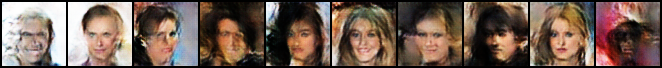

In [ ]:
from PIL import Image
#show result/image
Image.open('images/fake_images-0010.png')

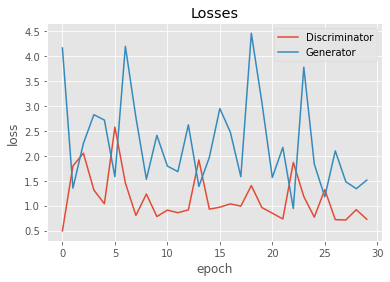

In [ ]:
# plot the loss
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

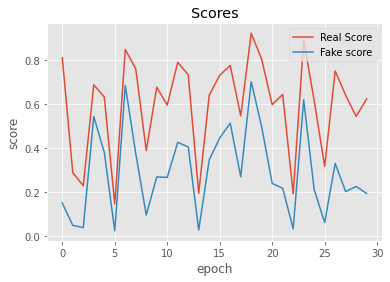

In [ ]:
# plot the score
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH_G = "gdrive/MyDrive/celeba/model_g.pth"
torch.save(G.state_dict(), PATH_G)

In [ ]:
PATH_D = "gdrive/MyDrive/celeba/model_d.pth"
torch.save(D.state_dict(), PATH_D)

### install library from https://github.com/w86763777/pytorch-gan-metrics.git
Currently, this package supports following metrics:
- Inception Score (IS)
- Fréchet Inception Distance (FID)

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = "gdrive/MyDrive/celeba/model_g.pth"
G = Generator(CFG.nc, CFG.nz, CFG.ngf).to(device)
G.load_state_dict(torch.load(PATH))
G.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Sigmoid()
  )
)

In [ ]:
# clone is repo: https://github.com/w86763777/pytorch-gan-metrics.git and install pytorch-gan-metrics
!git clone https://github.com/w86763777/pytorch-gan-metrics.git
!pip install pytorch-gan-metrics

Cloning into 'pytorch-gan-metrics'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 168 (delta 89), reused 128 (delta 53), pack-reused 0
Receiving objects: 100% (168/168), 47.41 KiB | 1.39 MiB/s, done.
Resolving deltas: 100% (89/89), done.
     |████████████████████████████████| 25.9 MB 1.3 MB/s 
  Created wheel for pytorch-gan-metrics: filename=pytorch_gan_metrics-0.4.1-py3-none-any.whl size=17524 sha256=6e40c28c8f82db256c844b529f357190333b6ce1b1cd4f0f64bafc9d2c17cb35
  Stored in directory: /root/.cache/pip/wheels/60/6a/0f/5266df3028505c4d35deff810633775536b955f8264f62c772
Successfully built pytorch-gan-metrics
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is 

### Follow the repo's instruction


In [ ]:
%cd /content/pytorch-gan-metrics

/content/pytorch-gan-metrics


In [ ]:
#### Prepare Statistics for FID
!python -m pytorch_gan_metrics.calc_fid_stats --path ../data/celeba/img_align_celeba/img_align_celeba --output statistics.npz

tcmalloc: large alloc 3319382016 bytes == 0x559510f5c000 @  0x7fca0a3ea1e7 0x7fca07f2a46e 0x7fca07f7ac7b 0x7fca07f7b35f 0x7fca0801d103 0x55948e79a4b0 0x55948e79a240 0x55948e80e0f3 0x55948e808ced 0x55948e79bbda 0x55948e809915 0x55948e808ced 0x55948e79bbda 0x55948e80a737 0x55948e79bafa 0x55948e809915 0x55948e8089ee 0x55948e8086f3 0x55948e806b60 0x55948e79a349 0x55948e79a240 0x55948e80d973 0x55948e8089ee 0x55948e79bbda 0x55948e809915 0x55948e8089ee 0x55948e6daeb0 0x55948e8ac581 0x55948e8aa19a 0x55948e8a9e0c 0x7fca091d4bf7
tcmalloc: large alloc 3319382016 bytes == 0x5595d767c000 @  0x7fca0a3ea1e7 0x7fca07f2a46e 0x7fca07f7ac7b 0x7fca07f7ad97 0x7fca07f744a5 0x7fca0801f823 0x55948e79a544 0x55948e79a240 0x55948e80e627 0x55948e8089ee 0x55948e6dae2b 0x7fca07f67ef7 0x55948e79a437 0x55948e79a240 0x55948e80d973 0x55948e8089ee 0x55948e79bbda 0x55948e80a737 0x55948e79bafa 0x55948e809915 0x55948e8089ee 0x55948e8086f3 0x55948e806b60 0x55948e79a349 0x55948e79a240 0x55948e80d973 0x55948e8089ee 0x55948e79

#### calculate the Inception Score (IS) and Fréchet Inception Distance (FID)

In [ ]:
# import function from pytorch_gan_metrics 
from pytorch_gan_metrics import (get_inception_score,
                                 get_fid,
                                 get_inception_score_and_fid)

# create the Generator Dataset. returns the image, generated from the Generator network
class GeneratorDataset(Dataset):
    def __init__(self, G, z_dim):
        self.G = G
        self.z_dim = z_dim
    
    def __len__(self):
        return 500
    
    def __getitem__(self, index):
        return self.G(torch.randn(1, self.z_dim, 1, 1).cuda())[0]

# define dataset
dataset = GeneratorDataset(G, z_dim=CFG.nz)
#create dataloader
loader = DataLoader(dataset, batch_size=50, num_workers=0)

# Inception Score
IS, IS_std = get_inception_score(loader)
# Frechet Inception Distance
FID = get_fid(loader, 'statistics.npz')
# Inception Score + Frechet Inception Distance
(IS, IS_std), FID = get_inception_score_and_fid(
    loader, 'statistics.npz')

In [ ]:
# print the result
print(f"Inception Score: {IS} (std:{IS_std})\nFréchet Inception Distance: {FID}")

Inception Score: 2.1317291507504077 (std:0.17120913810180735)
Fréchet Inception Distance: 144.55797537405948


#### Измерим IS и FID у исходного датасета

In [ ]:
from torch.utils.data import RandomSampler, DataLoader, Subset

# define dataset
dataset = CelebADataset('../data/celeba/img_align_celeba/img_align_celeba', transform)
num_train_samples = 500
sample_ds = Subset(dataset, np.arange(num_train_samples))
sample_sampler = RandomSampler(sample_ds)
#create dataloader
loader = DataLoader(sample_ds, sampler=sample_sampler, batch_size=50)

# Inception Score
IS, IS_std = get_inception_score(loader)
# Frechet Inception Distance
FID = get_fid(loader, 'statistics.npz')
# Inception Score + Frechet Inception Distance
(IS, IS_std), FID = get_inception_score_and_fid(
    loader, 'statistics.npz')

In [ ]:
# print the result
print(f"Inception Score: {IS} (std:{IS_std})\nFréchet Inception Distance: {FID}")

Inception Score: 3.1145284169947116 (std:0.3676933857521101)
Fréchet Inception Distance: 89.78164919392108


## Geometry Score
from this repo: https://github.com/KhrulkovV/geometry-score
It is a novel measure of performance of a GAN by comparing geometrical properties of the underlying data manifold and the generated one, which provides both qualitative and quantitative means for evaluation. 

![Geometry Score](https://github.com/KhrulkovV/geometry-score/blob/master/assets/manif.png?raw=true)

In [120]:
%cd /content
!git clone https://github.com/KhrulkovV/geometry-score.git

/content
Cloning into 'geometry-score'...
remote: Enumerating objects: 114, done.
remote: Total 114 (delta 0), reused 0 (delta 0), pack-reused 114
Receiving objects: 100% (114/114), 4.01 MiB | 14.01 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [121]:
!pip install gudhi

     |████████████████████████████████| 28.2 MB 1.3 MB/s 


In [ ]:
dataset = CelebADataset(CFG.img_folder, transform)
dataloader = DataLoader(dataset, batch_size=CFG.batch_size, shuffle=True)

In [ ]:
import sys 
sys.path.insert(0, "/content/geometry-score")
import gs
for i, (images) in enumerate(dataloader):
  x = images.numpy()
  break
print(x.shape)
x = np.reshape(x, (-1, 3*64*64))
rltx = gs.rlts(x, n=100, L_0=32, i_max=10, gamma=1.0/8)

(1024, 3, 64, 64)
Done 0/100
Done 10/100
Done 20/100
Done 30/100
Done 40/100
Done 50/100
Done 60/100
Done 70/100
Done 80/100
Done 90/100


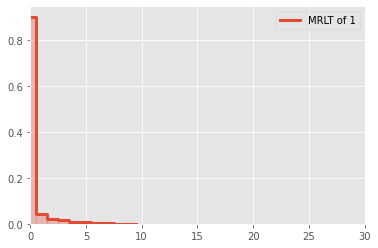

In [ ]:
mrlt = np.mean(rltx, axis=0)
gs.fancy_plot(mrlt, label='MRLT of 1')
plt.xlim([0, 30])
plt.legend()

In [ ]:
dataset = GeneratorDataset(G,  CFG.nz)
loader = torch.utils.data.DataLoader(dataset, batch_size=CFG.batch_size, num_workers=0)
for i, (images) in enumerate(loader):
  x = images.detach().cpu().numpy()
  break
print(x.shape)
x = np.reshape(x, (-1, 3*64*64))
rlty = gs.rlts(x, n=100, L_0=32, i_max=10, gamma=1.0/8)

(500, 3, 64, 64)
Done 0/100
Done 10/100
Done 20/100
Done 30/100
Done 40/100
Done 50/100
Done 60/100
Done 70/100
Done 80/100
Done 90/100


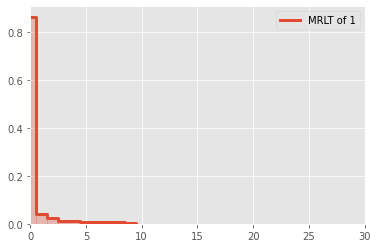

In [ ]:
mrlt = np.mean(rlty, axis=0)
gs.fancy_plot(mrlt, label='MRLT of 1')
plt.xlim([0, 30])
plt.legend()

In [ ]:
# Compute score
print(f"Geometry Score: {gs.geom_score(rltx, rlty)}")

Geometry Score: 0.0014030909673523344


## Model 2 score: Add more layers

In [ ]:
# Define new networks: double the size with CFG.nfg*2 and CFG.ndf*2
#define the loss and optimizer

In [141]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        """
          nc - количество слоев в возвращаемом (и исходном изображениях)
          nz - длина входного вектора латентного пространства
          ngf - размер feature map'ов в генераторе
        """
        #ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu 
        #ConvTranspose2d - BatchNorm - Relu - ConvTranspose2d - Tanh
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        """
          nc - количество слоев во входных изображениях
          ndf - размер feature map'ов в дискриминаторе
        """
        #conv2d - leaky - conv2d - batchnorm - leaky - conv2d - batchnorm - leaky - conv - batchnorm - leaky - conv2d
        super(Discriminator, self).__init__()
        self.main1 = nn.Sequential(
            SpectralNorm(nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(ndf * 8)
        )
        self.main2 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0)),
            nn.Flatten(),
            nn.Sigmoid()
        )
        self.ndf = ndf

    # нужно ли использовать сигмоиду? наверное нет, так как мы пользуемся спектральной нормой а она ее заменяет

    def forward(self, x, matching=False):
        x = self.main1(x)
        feature = x.view(-1, self.ndf*8*4*4)
        x = self.main2(x)
        if matching == True:
            return feature, x
        else:
            return x

In [142]:
# Create model: Generator and Discriminator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# create new Generator model
G = Generator(CFG.nc, CFG.nz, CFG.ngf).to(device)

D = Discriminator(CFG.nc, CFG.ndf).to(device)

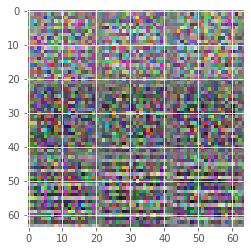

In [143]:
# test the generator: create random vector to fit the networks, then show the result with matplotlib
noise = torch.randn(2, CFG.nz, 1, 1, device=device)
y = G(noise)

# Вывод необученного генератора
plt.imshow(y.detach().cpu()[0].view(64, 64, 3))
plt.show()

In [144]:
image = dataset[0].unsqueeze(0).to(device)
print(y.shape)
print(image.shape)
print(D(y))
print(D(image))

torch.Size([2, 3, 64, 64])
torch.Size([1, 3, 64, 64])
tensor([[0.4833],
        [0.5031]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.6434]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [145]:
## define the loss, and optimizers for generator and discrimator networks
criterion = nn.BCELoss()

criterion_g_mse = nn.MSELoss()
criterion_g_bce = nn.BCELoss()
criterion_d = nn.BCELoss()

## Define the optimizer for generator and discrimator
optimizer_g = torch.optim.Adam(G.parameters(), lr=CFG.lr, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(D.parameters(), lr=CFG.lr, betas=(0.5, 0.999))

In [146]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    optimizer_g.zero_grad()
    optimizer_d.zero_grad()

def train_discriminator(images):
    LABEL_SMOOTH_real = (1.0 - 0.7) * torch.rand(images.size(0), 1) + 0.7
    # LABEL_SMOOTH_fake = (0.3 - 0.0) * torch.rand(images.size(0), 1) + 0.0
    LABEL_SMOOTH_fake = (1.0 - LABEL_SMOOTH_real)
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(images.size(0), 1).to(device)*LABEL_SMOOTH_real.to(device)
    fake_labels = torch.zeros(images.size(0), 1).to(device)*LABEL_SMOOTH_fake.to(device)

    real_preds = D(images).to(device)

    d_loss_real = criterion(real_preds, real_labels)
    real_score = torch.mean(real_preds).item()

    # Loss for fake images
    z = torch.randn(images.size(0), CFG.nz, 1, 1).to(device)
    fake_images = G(z).to(device)

    fake_preds = D(fake_images).to(device)

    d_loss_fake = criterion(fake_preds, fake_labels)
    fake_score = torch.mean(fake_preds).item()

    # Sum losses
    loss = d_loss_real + d_loss_fake

    reset_grad()
    # Compute gradients
    loss.backward()

    # Adjust the parameters using backprop
    optimizer_d.step()
    
    return loss.item(), real_score, fake_score

In [147]:
def train_generator(images):
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    z = torch.randn(CFG.batch_size, CFG.nz, 1,1).to(device)
    fake_images = G(z).to(device)
    labels = torch.ones(CFG.batch_size, 1).to(device)
    
    feature_real, _ = D(images.detach(), matching=True)
    feature_fake, _ = D(fake_images, matching=True)
    feature_real = torch.mean(feature_real,0)
    feature_fake = torch.mean(feature_fake,0)
    # calculate the generator loss
    loss_mse = criterion_g_mse(feature_fake, feature_real.detach())
    loss_bce = criterion_g_bce(D(fake_images), labels)
    # loss_bce = 0
    loss = loss_mse + loss_bce
    
    # Reset gradients
    reset_grad()
    # Backprop and optimize
    loss.backward()
    optimizer_g.step()

    return loss, fake_images

In [148]:
# save some photo to show the result
def save_fake_images(index):
    sample_vectors = torch.randn(10, CFG.nz , 1 , 1).to(CFG.device)
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(fake_images, os.path.join(CFG.sample_dir, fake_fname), nrow=10)

In [149]:
%%time
total_step = len(dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

for epoch in range(num_epochs):
    for i, (images) in enumerate(dataloader):
        # Load a batch & transform to vectors
        images = images.to(device)
        
        # Train the discriminator  
        d_loss, real_score, fake_score = train_discriminator(images)
        # Train the generator
        g_loss, _ = train_generator(images)
        # Inspect the losses
        if (i+1) % 50 == 0:
            d_losses.append(d_loss)
            g_losses.append(g_loss)
            real_scores.append(real_score)
            fake_scores.append(fake_score)
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss, g_loss, 
                          real_score, fake_score))
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/10], Step [50/198], d_loss: 0.8197, g_loss: 4.0442, D(x): 0.88, D(G(z)): 0.25
Epoch [0/10], Step [100/198], d_loss: 0.9492, g_loss: 2.6965, D(x): 0.52, D(G(z)): 0.11
Epoch [0/10], Step [150/198], d_loss: 1.2068, g_loss: 2.6606, D(x): 0.62, D(G(z)): 0.40
Saving fake_images-0001.png
Epoch [1/10], Step [50/198], d_loss: 0.9952, g_loss: 2.5633, D(x): 0.53, D(G(z)): 0.20
Epoch [1/10], Step [100/198], d_loss: 1.1256, g_loss: 1.9086, D(x): 0.45, D(G(z)): 0.21
Epoch [1/10], Step [150/198], d_loss: 0.9413, g_loss: 2.9128, D(x): 0.62, D(G(z)): 0.26
Saving fake_images-0002.png
Epoch [2/10], Step [50/198], d_loss: 1.0954, g_loss: 2.0469, D(x): 0.43, D(G(z)): 0.19
Epoch [2/10], Step [100/198], d_loss: 1.2477, g_loss: 3.8324, D(x): 0.75, D(G(z)): 0.50
Epoch [2/10], Step [150/198], d_loss: 0.9904, g_loss: 2.5564, D(x): 0.58, D(G(z)): 0.27
Saving fake_images-0003.png
Epoch [3/10], Step [50/198], d_loss: 1.0494, g_loss: 2.0718, D(x): 0.53, D(G(z)): 0.26
Epoch [3/10], Step [100/198], d_loss: 1.

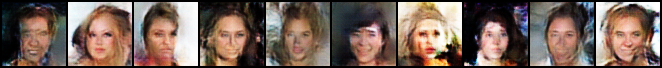

In [150]:
from PIL import Image
#show result/image
Image.open('images/fake_images-0010.png')

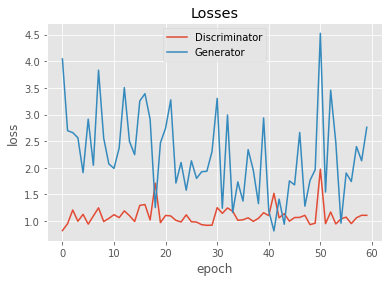

In [174]:
# plot the loss
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

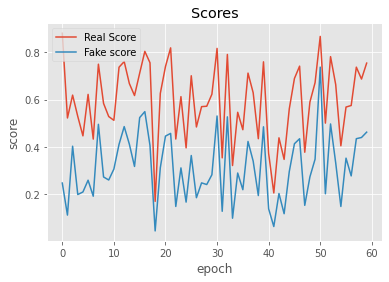

In [175]:
# plot the score
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [153]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [176]:
PATH_G = "gdrive/MyDrive/celeba/model_g_regularized_4.pth"
torch.save(G.state_dict(), PATH_G)

In [177]:
PATH_D = "gdrive/MyDrive/celeba/model_d_regularized_4.pth"
torch.save(D.state_dict(), PATH_D)

In [156]:
# clone is repo: https://github.com/w86763777/pytorch-gan-metrics.git and install pytorch-gan-metrics
!git clone https://github.com/w86763777/pytorch-gan-metrics.git
!pip install pytorch-gan-metrics

fatal: destination path 'pytorch-gan-metrics' already exists and is not an empty directory.


In [165]:
%cd /content/pytorch-gan-metrics

/content/pytorch-gan-metrics


In [113]:
#### Prepare Statistics for FID
!python -m pytorch_gan_metrics.calc_fid_stats --path ../data/celeba/img_align_celeba/img_align_celeba --output statistics.npz

Downloading: "https://github.com/w86763777/pytorch-gan-metrics/releases/download/v0.1.0/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:04<00:00, 19.7MB/s]
tcmalloc: large alloc 3319382016 bytes == 0x55e8d4516000 @  0x7f4727d951e7 0x7f47258d546e 0x7f4725925c7b 0x7f472592635f 0x7f47259c8103 0x55e852e5f4b0 0x55e852e5f240 0x55e852ed30f3 0x55e852ecdced 0x55e852e60bda 0x55e852ece915 0x55e852ecdced 0x55e852e60bda 0x55e852ecf737 0x55e852e60afa 0x55e852ece915 0x55e852ecd9ee 0x55e852ecd6f3 0x55e852ecbb60 0x55e852e5f349 0x55e852e5f240 0x55e852ed2973 0x55e852ecd9ee 0x55e852e60bda 0x55e852ece915 0x55e852ecd9ee 0x55e852d9feb0 0x55e852f71581 0x55e852f6f19a 0x55e852f6ee0c 0x7f4726b7fbf7
tcmalloc: large alloc 3319382016 bytes == 0x55e99aab2000 @  0x7f4727d951e7 0x7f47258d546e 0x7f4725925c7b 0x7f4725925d97 0x7f472591f4a5 0x7f47259ca823 0x55e852e5f544 0x55e852e5f240 0x55e852ed3627 0x55e852ecd9ee 0x55e852d9fe2b 0x7f4725

In [166]:
# import function from pytorch_gan_metrics 
from pytorch_gan_metrics import (get_inception_score,
                                 get_fid,
                                 get_inception_score_and_fid)

# create the Generator Dataset. returns the image, generated from the Generator network
class GeneratorDataset(Dataset):
    def __init__(self, G, z_dim):
        self.G = G
        self.z_dim = z_dim
    
    def __len__(self):
        return 500
    
    def __getitem__(self, index):
        return self.G(torch.randn(1, self.z_dim, 1, 1).cuda())[0]

# define dataset
dataset = GeneratorDataset(G, z_dim=CFG.nz)
#create dataloader
loader = torch.utils.data.DataLoader(dataset, batch_size=50, num_workers=0)

# Inception Score
IS, IS_std = get_inception_score(loader)
# Frechet Inception Distance
FID = get_fid(loader, 'statistics.npz')
# Inception Score + Frechet Inception Distance
(IS, IS_std), FID = get_inception_score_and_fid(
    loader, 'statistics.npz')

In [159]:
## print the Inception Score, Fréchet Inception Distance
# print the result
print(f"Inception Score: {IS} (std:{IS_std})\nFréchet Inception Distance: {FID}")

Inception Score: 2.664231108967135 (std:0.28572267351435177)
Fréchet Inception Distance: 163.94996528385533


In [169]:
%cd /content
!git clone https://github.com/KhrulkovV/geometry-score.git

/content
fatal: destination path 'geometry-score' already exists and is not an empty directory.


In [161]:
!pip install gudhi

In [162]:
import sys 
sys.path.insert(0, "/content/geometry-score")
import gs

for i, (images) in enumerate(dataloader):
  x = images.numpy()
  break
x = np.reshape(x, (-1, 3*64*64))
rltx = gs.rlts(x, n=100, L_0=32, i_max=10, gamma=1.0/8)
dataset = GeneratorDataset(G,  CFG.nz)
loader = torch.utils.data.DataLoader(dataset, batch_size=CFG.batch_size, num_workers=0)
for i, (images) in enumerate(loader):
  x = images.detach().cpu().numpy()
  break
x = np.reshape(x, (-1, 3*64*64))
rlty = gs.rlts(x, n=100, L_0=32, i_max=10, gamma=1.0/8)
#print Geometry Score
print(f"Geometry Score: {gs.geom_score(rltx, rlty)}")

Done 0/100
Done 10/100
Done 20/100
Done 30/100
Done 40/100
Done 50/100
Done 60/100
Done 70/100
Done 80/100
Done 90/100
Done 0/100
Done 10/100
Done 20/100
Done 30/100
Done 40/100
Done 50/100
Done 60/100
Done 70/100
Done 80/100
Done 90/100
Geometry Score: 0.00665751119363288


In [163]:
%%time
total_step = len(dataloader)
# d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

for epoch in range(num_epochs):
    for i, (images) in enumerate(dataloader):
        # Load a batch & transform to vectors
        images = images.to(device)
        
        # Train the discriminator  
        d_loss, real_score, fake_score = train_discriminator(images)
        # Train the generator
        g_loss, _ = train_generator(images)
        # Inspect the losses
        if (i+1) % 50 == 0:
            d_losses.append(d_loss)
            g_losses.append(g_loss)
            real_scores.append(real_score)
            fake_scores.append(fake_score)
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss, g_loss, 
                          real_score, fake_score))
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/10], Step [50/198], d_loss: 1.2513, g_loss: 3.3037, D(x): 0.82, D(G(z)): 0.53
Epoch [0/10], Step [100/198], d_loss: 1.1435, g_loss: 1.2400, D(x): 0.35, D(G(z)): 0.13
Epoch [0/10], Step [150/198], d_loss: 1.2454, g_loss: 2.9904, D(x): 0.79, D(G(z)): 0.53
Saving fake_images-0001.png
Epoch [1/10], Step [50/198], d_loss: 1.1841, g_loss: 1.1601, D(x): 0.32, D(G(z)): 0.10
Epoch [1/10], Step [100/198], d_loss: 1.0139, g_loss: 1.7344, D(x): 0.55, D(G(z)): 0.29
Epoch [1/10], Step [150/198], d_loss: 1.0224, g_loss: 1.3754, D(x): 0.47, D(G(z)): 0.22
Saving fake_images-0002.png
Epoch [2/10], Step [50/198], d_loss: 1.0605, g_loss: 2.3403, D(x): 0.71, D(G(z)): 0.42
Epoch [2/10], Step [100/198], d_loss: 0.9935, g_loss: 1.9558, D(x): 0.63, D(G(z)): 0.34
Epoch [2/10], Step [150/198], d_loss: 1.0509, g_loss: 1.3261, D(x): 0.43, D(G(z)): 0.19
Saving fake_images-0003.png
Epoch [3/10], Step [50/198], d_loss: 1.1559, g_loss: 2.9365, D(x): 0.76, D(G(z)): 0.48
Epoch [3/10], Step [100/198], d_loss: 1.

In [167]:
## print the Inception Score, Fréchet Inception Distance
# print the result
print(f"Inception Score: {IS} (std:{IS_std})\nFréchet Inception Distance: {FID}")

Inception Score: 2.196734372206402 (std:0.18995513444752635)
Fréchet Inception Distance: 136.21449821117778


In [170]:
import sys 
sys.path.insert(0, "/content/geometry-score")
import gs

for i, (images) in enumerate(dataloader):
  x = images.numpy()
  break
x = np.reshape(x, (-1, 3*64*64))
rltx = gs.rlts(x, n=100, L_0=32, i_max=10, gamma=1.0/8)
dataset = GeneratorDataset(G,  CFG.nz)
loader = torch.utils.data.DataLoader(dataset, batch_size=CFG.batch_size, num_workers=0)
for i, (images) in enumerate(loader):
  x = images.detach().cpu().numpy()
  break
x = np.reshape(x, (-1, 3*64*64))
rlty = gs.rlts(x, n=100, L_0=32, i_max=10, gamma=1.0/8)
#print Geometry Score
print(f"Geometry Score: {gs.geom_score(rltx, rlty)}")

Done 0/100
Done 10/100
Done 20/100
Done 30/100
Done 40/100
Done 50/100
Done 60/100
Done 70/100
Done 80/100
Done 90/100
Done 0/100
Done 10/100
Done 20/100
Done 30/100
Done 40/100
Done 50/100
Done 60/100
Done 70/100
Done 80/100
Done 90/100
Geometry Score: 0.0066021422874416825


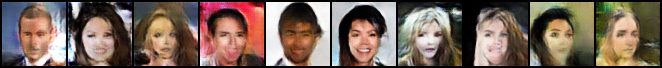

In [172]:
from PIL import Image
#show result/image
Image.open('images/fake_images-0006.png')

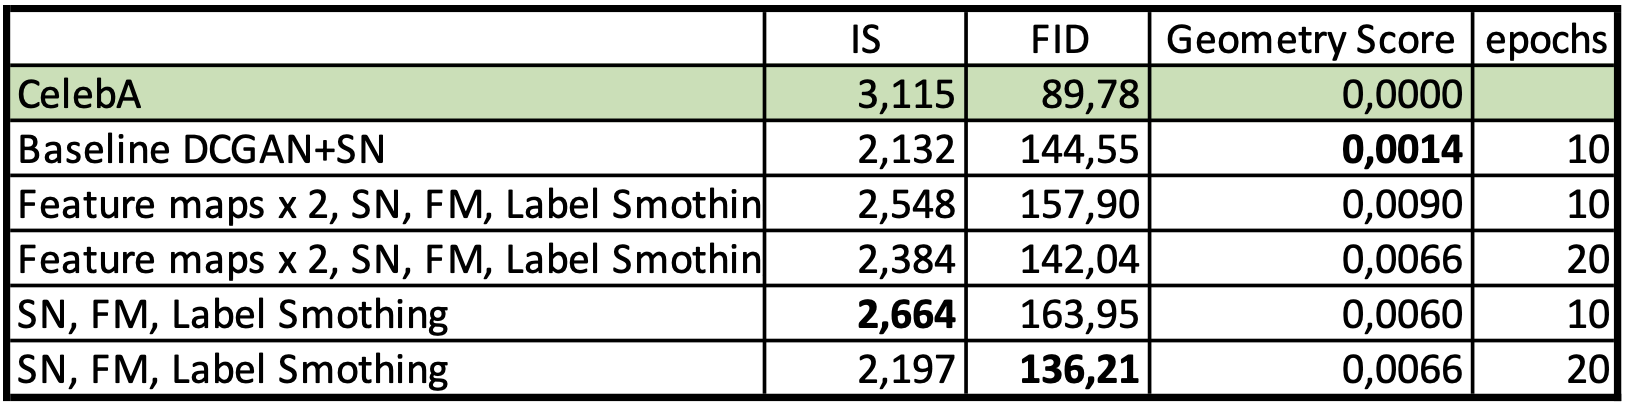

In [2]:
Image.open('Результаты.png')

In [ ]:
# Для того чтобы не скакал Frechet Distance наверное нужно было применять Jacobian Clamping